### Import Python Modules

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Datasets/CarObjectDetection.zip -d /content/sample_data

Archive:  /content/drive/MyDrive/Datasets/CarObjectDetection.zip
   creating: /content/sample_data/CarObjectDetection/
  inflating: /content/sample_data/CarObjectDetection/gt.csv  
   creating: /content/sample_data/CarObjectDetection/test/
  inflating: /content/sample_data/CarObjectDetection/test/vid_5_25100.jpg  
  inflating: /content/sample_data/CarObjectDetection/test/vid_5_25120.jpg  
  inflating: /content/sample_data/CarObjectDetection/test/vid_5_25140.jpg  
  inflating: /content/sample_data/CarObjectDetection/test/vid_5_25160.jpg  
  inflating: /content/sample_data/CarObjectDetection/test/vid_5_25180.jpg  
  inflating: /content/sample_data/CarObjectDetection/test/vid_5_25200.jpg  
  inflating: /content/sample_data/CarObjectDetection/test/vid_5_25220.jpg  
  inflating: /content/sample_data/CarObjectDetection/test/vid_5_25240.jpg  
  inflating: /content/sample_data/CarObjectDetection/test/vid_5_25260.jpg  
  inflating: /content/sample_data/CarObjectDetection/test/vid_5_26320.jpg  


In [3]:
import os
import cv2   # Image Processing
import numpy as np # Vector / Array Data Structures
import pandas as pd # Read Excel/CSV/Text Files
import matplotlib.pyplot as plt # Visualizing Data


# Data Augmentation
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch # Deep Learning Models
from torch.utils.data import Dataset, DataLoader

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.rpn import AnchorGenerator
from PIL import Image

### Load Dataset

In [4]:
#dataset = "/Users/krish/Documents/Projects/Datasets/CarObjectDetection"
dataset = r"/content/sample_data/CarObjectDetection"

os.listdir(dataset)

['test', 'train', 'gt.csv']

In [5]:
# Train / Test images
train_images = os.listdir(os.path.join(dataset, 'train'))
test_images = os.listdir(os.path.join(dataset, 'test'))

len(train_images),len(test_images)


(1001, 175)

In [6]:
# Ground Truth
gt_df = pd.read_csv(os.path.join(dataset, 'gt.csv'))
gt_df

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422
...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,198.321729,49.235251,236.223284
555,vid_4_9880.jpg,329.876184,156.482351,536.664239,250.497895
556,vid_4_9900.jpg,0.000000,168.295823,141.797524,239.176652
557,vid_4_9960.jpg,487.428988,172.233646,616.917699,228.839864


### Visualize Ground truth

In [7]:
img_name = gt_df.iloc[0].image
image_path = os.path.join(dataset, "train", img_name)
image = plt.imread(image_path)

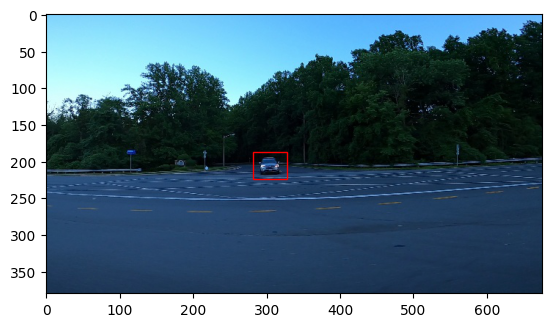

In [8]:
from matplotlib.patches import Rectangle

rect = gt_df[gt_df["image"]==img_name][["xmin","ymin","xmax","ymax"]].values

xmin, ymin, xmax, ymax = rect[0]
plt.imshow(image)
plt.gca().add_patch(Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none'))

### Pytorch Dataset

In [9]:
from PIL import Image

class CarDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_dir, transforms=None):
        self.image_dir = image_dir # dir to image files
        self.transforms = transforms # Transforms contains logic of Data Augmentation
        self.image_ids = df["image"].unique()
        self.df = df

    def __len__(self):
        return self.image_ids.shape[0]

    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx]
        records = self.df[self.df["image"] == image_id]
        image = cv2.imread(f"{self.image_dir}/{image_id}", cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        image = torch.tensor(image)
        image = image.permute(2,0,1)


        boxes = records[["xmin", "ymin", "xmax", "ymax"]].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # There is only one class
        labels = torch.ones((records.shape[0]), dtype=torch.int64)

        target = {}
        target["boxes"] = torch.tensor(boxes)
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = area


        if self.transforms:
            sample = {"image": image, "boxes": target["boxes"], "labels": labels}
            sample = self.transforms(**sample)
            image = sample["image"]
            target["boxes"] = torch.stack(tuple(map(torch.tensor, zip(*sample["boxes"])))).permute(1, 0)

        return image, target, image_id

In [10]:
from torchvision import transforms as T

transforms = torch.nn.Sequential
(
    T.PILToTensor(),
    T.ConvertImageDtype(torch.float),
    T.RandomHorizontalFlip(0.5),
    T.RandomVerticalFlip(0.5),
    T.CenterCrop(10),
    T.RandomRotation(degrees=(0, 180)),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
)

# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={"format": "pascal_voc", "label_fields": ["labels"]})

# transforms = get_train_transform()
# train_dataset = CarDetectionDataset(os.path.join(dataset, 'train'), train_df, transforms)
# len(train_dataset)

In [11]:
# Load model pretrained on COCO
model = fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 206MB/s]


In [12]:
num_classes = 2 # 1 class (car) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace pre-trained head with new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [13]:
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [14]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_df = pd.read_csv(os.path.join(dataset, 'gt.csv'))
dir_train = os.path.join(dataset, 'train')
transforms = get_train_transform()
train_ds = CarDetectionDataset(train_df, dir_train)

train_dl = DataLoader(train_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [16]:
images, targets, image_ids = next(iter(train_dl))


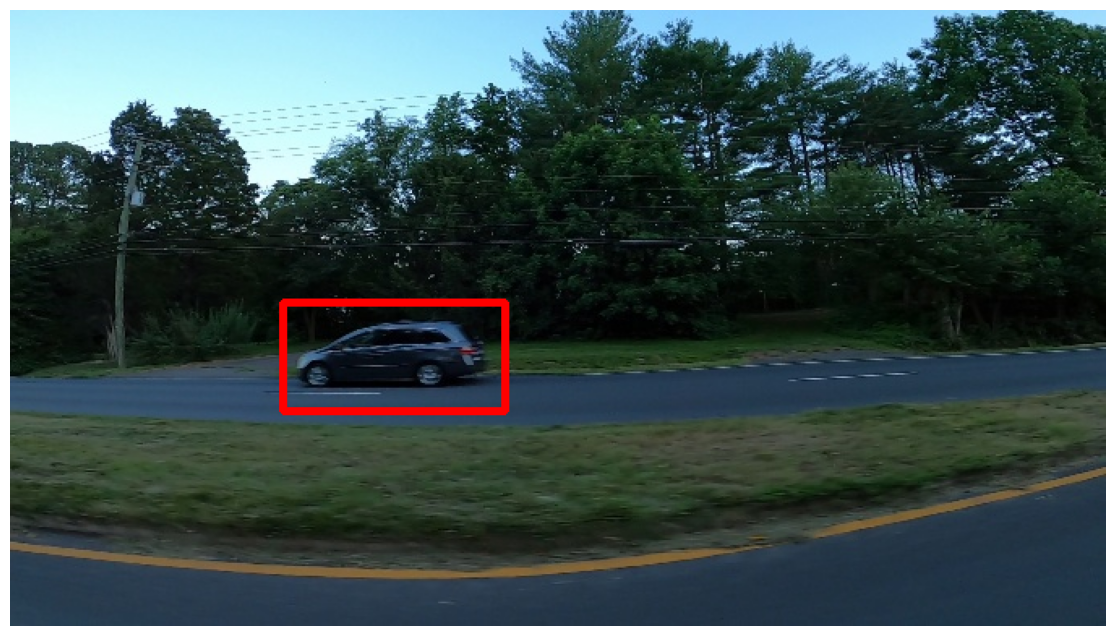

In [17]:
boxes = targets[6]['boxes'].numpy().astype(np.int32)
sample = images[6].permute(1,2,0).numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2] - box[0], box[3] - box[1]),
                  (220, 0, 0), 3)

ax.set_axis_off()
ax.imshow(sample)

In [18]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0005, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 5

In [ ]:
itr = 1
model.train()

for epoch in range(num_epochs):
    loss_values = []
    for images, targets, image_ids in train_dl:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        print(f"Iteration #{itr} loss: {loss_value}")
        loss_values.append(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()


        itr += 1

    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {sum(loss_values) / len(loss_values)}")

Iteration #1 loss: 0.7840963176050657
Iteration #2 loss: 0.17644240477374276
Iteration #3 loss: 0.2538756904779783
Iteration #4 loss: 0.1730684305274472
Iteration #5 loss: 0.15976367770698202
Iteration #6 loss: 0.2677186689173759
Iteration #7 loss: 0.21751560881831764
Iteration #8 loss: 0.29400378711351116
Iteration #9 loss: 0.17850313785015393
Iteration #10 loss: 0.08793729631785002
Iteration #11 loss: 0.06041796213404592
Iteration #12 loss: 0.055658753428373224
Iteration #13 loss: 0.05543109599835051
Iteration #14 loss: 0.09014467079126143
Iteration #15 loss: 0.10078303981509232
Iteration #16 loss: 0.10096505053234718
Iteration #17 loss: 0.08590499061261848
Iteration #18 loss: 0.07438058738597078
Iteration #19 loss: 0.06808305882463354
Iteration #20 loss: 0.1642616535984935
Iteration #21 loss: 0.12961983443675373
Iteration #22 loss: 0.07613539605758993
Iteration #23 loss: 0.06849719790672931
Iteration #24 loss: 0.0777392603018453
